In [25]:
import os, warnings

import torch
from transformers import *
from transformers.utils import logging as hf_logging
from fastai.text.all import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

seed=1

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [26]:
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [27]:
def get_oversampled_dls(dls, seed=1, baseline_factor=1.0, noise_limit=0.15, label='speaker'):
    df_train = dls.train.items
    max_dialog = df_train[label].value_counts().max()

    dfs_oversampled = [df_train]
    for _, group in df_train.groupby('speaker'):
        rand_mult = random.uniform(baseline_factor-noise_limit, baseline_factor + noise_limit)
        sample_amt_to_max = max_dialog - len(group)
        
        sample_amt = max(int(sample_amt_to_max * rand_mult), len(group))
        
        dfs_oversampled.append(group.sample(sample_amt, replace=True, random_state=seed))
        
    dls.train.items = pd.concat(dfs_oversampled)
    return dls

In [28]:
data_path = Path('../data')
df = pd.read_csv(data_path/'train21_shuffled.csv')
df_test = pd.read_csv(data_path/'test21_shuffled.csv')

,season,episode,scene,line_text,speaker,deleted
0,3,16,29,"Don't hurt that bat, Creed! It's a living thing with feelings and a family!",Kelly,False
1,7,7,27,"I cancelled my plans to come to this thing, and they repay me with this?",Kevin,False
2,8,13,25,"Oh, yes. Oh, what a beautiful child. Prominent forehead, short arms, tiny nose. You will lead millions... [whispers] willingly, or as slaves.",Dwight,False
3,2,17,18,Brad Pitt. Also there will be no bonuses.,Dwight,False
4,5,4,32,"Okay, alright. Hey, you know what? I would appreciate it if people would stop storming off the stage.",Michael,False
...,...,...,...,...,...,...
7827,9,7,32,Yeah.,Pam,False
7828,4,3,25,Alright. Well fight it out amongst yourselves. I was thinking Pammy but boys night out is also good.,Michael,False
7829,7,8,19,Rachel.,Kelly,False
7830,8,21,19,[chuckling] Okay.,Andy,False


In [29]:
n_labels = len(df['speaker'].unique())

21

In [30]:
# model_cls = AutoModelForSequenceClassification

pretrained_model_name = 'bert-base-uncased'

# config = AutoConfig.from_pretrained(pretrained_model_name)
# config.num_labels = n_labels

# hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
#     pretrained_model_name,
#     model_cls=model_cls,
#     config=config
# )

'bert-base-uncased'

In [31]:
# blocks = (
#     TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
#     CategoryBlock
# )
# dblock = DataBlock(
#     blocks=blocks,
#     get_x=ColReader('line_text'),
#     get_y=ColReader('speaker'),
#     splitter=RandomSplitter(valid_pct=0.1, seed=seed)
# )
# dls = dblock.dataloaders(df, bs=8)
# test_dl = dls.test_dl(df_test, with_labels='True', label_col='speaker')

In [32]:
# dls = get_oversampled_dls(dls, seed=seed)

In [33]:
# dls.show_batch(dataloaders=dls, max_n=4)

In [34]:
%%time

noise_limits = [0.05, 0.1, 0.15]
batch_sizes = [8, 16]
lrs = [1e-3, 1e-4, 1e-2]

for noise in noise_limits:
    for bs in batch_sizes:
        for lr in lrs:
            learn = BlearnerForSequenceClassification.from_data(
                df, 
                pretrained_model_name, 
                dl_kwargs={"bs": bs, "seed": seed},
                learner_kwargs={"metrics": accuracy},
                text_attr='line_text',
                label_attr='speaker',
                n_labels = n_labels,
                dblock_splitter=RandomSplitter(valid_pct=0.1, seed=seed)
            )
            
            print(f'lr: {lr}, bs: {bs}, noise: {noise}')
            learn.dls = get_oversampled_dls(learn.dls, seed=seed, noise_limit=noise)
            test_dl = learn.dls.test_dl(df_test, with_labels='True', label_col='speaker')

            learn.fit_one_cycle(8, lr_max=lr)
            
            print(learn.validate(dl=test_dl))
            
            print("validation done!")

lr: 0.001, bs: 8, noise: 0.05


epoch,train_loss,valid_loss,accuracy,time
0,2.372758,2.482676,0.249944,01:59
1,2.452139,2.421787,0.267072,02:00
2,2.420624,2.402043,0.265044,02:01
3,2.369622,2.379817,0.267748,01:58
4,2.276654,2.343791,0.278116,01:57
5,2.312638,2.329892,0.286906,01:58
6,2.276136,2.319779,0.294794,01:57
7,2.327084,2.323126,0.293216,01:58


[2.3068268299102783, 0.2883043885231018]
validation done!
lr: 0.0001, bs: 8, noise: 0.05


epoch,train_loss,valid_loss,accuracy,time
0,2.486246,2.508957,0.239126,01:57
1,2.421334,2.463122,0.252648,02:00
2,2.412989,2.424824,0.256705,02:02
3,2.392786,2.411803,0.264142,02:02
4,2.446033,2.403677,0.259635,02:00
5,2.370053,2.392293,0.263692,01:58
6,2.383378,2.392687,0.265269,01:58
7,2.361327,2.391382,0.264368,02:01


[2.3654427528381348, 0.2715781331062317]
validation done!
lr: 0.01, bs: 8, noise: 0.05


epoch,train_loss,valid_loss,accuracy,time
0,2.557497,2.550843,0.239126,01:56
1,2.643357,2.560377,0.239126,01:59
2,2.682681,2.594440,0.239126,02:00
3,2.588759,2.548875,0.239126,01:58
4,2.605562,2.558660,0.239126,02:02
5,2.542002,2.530647,0.239126,02:03
6,2.580241,2.516248,0.239126,02:00
7,2.551785,2.513558,0.239126,02:02


[2.517245292663574, 0.2314862161874771]
validation done!
lr: 0.001, bs: 16, noise: 0.05


epoch,train_loss,valid_loss,accuracy,time
0,2.463448,2.478432,0.246338,01:08
1,2.448098,2.412311,0.263241,01:13
2,2.403065,2.386486,0.268199,01:13
3,2.301771,2.358612,0.278341,01:11
4,2.318176,2.356742,0.285328,01:12
5,2.266816,2.341139,0.289610,01:10
6,2.274980,2.328900,0.290962,01:11
7,2.226144,2.330910,0.290737,01:11


[2.3090882301330566, 0.2891981601715088]
validation done!
lr: 0.0001, bs: 16, noise: 0.05


epoch,train_loss,valid_loss,accuracy,time
0,2.523205,2.513991,0.238900,01:09
1,2.509685,2.472783,0.239802,01:10
2,2.385664,2.436381,0.254677,01:10
3,2.429121,2.419253,0.255803,01:10
4,2.474700,2.415279,0.258733,01:10
5,2.390319,2.403826,0.264142,01:11
6,2.373998,2.402957,0.263917,01:10
7,2.372542,2.402564,0.266396,01:11


[2.3784019947052, 0.2651940882205963]
validation done!
lr: 0.01, bs: 16, noise: 0.05


epoch,train_loss,valid_loss,accuracy,time
0,2.513739,2.481101,0.249718,01:09
1,2.598480,2.516646,0.239126,01:10
2,2.582622,2.580832,0.231913,01:10
3,2.491503,2.474971,0.249268,01:10
4,2.472821,2.472972,0.253099,01:10
5,2.478857,2.440066,0.260987,01:11
6,2.470140,2.428641,0.262790,01:11
7,2.469180,2.429970,0.258959,01:10


[2.4286653995513916, 0.25344738364219666]
validation done!
lr: 0.001, bs: 8, noise: 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.510516,2.464590,0.242732,02:16
1,2.488780,2.447596,0.254902,02:05
2,2.413244,2.402660,0.265044,02:03
3,2.377666,2.353390,0.283976,02:04
4,2.292615,2.318959,0.293442,02:09
5,2.298671,2.321878,0.295695,02:03
6,2.234285,2.312747,0.298625,02:02
7,2.253156,2.318216,0.300203,02:01


[2.3003005981445312, 0.29341164231300354]
validation done!
lr: 0.0001, bs: 8, noise: 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.521340,2.510082,0.239126,02:00
1,2.479461,2.458179,0.242055,02:00
2,2.467162,2.430791,0.256029,02:02
3,2.468300,2.415182,0.264593,02:01
4,2.383734,2.397909,0.265945,02:01
5,2.342867,2.398634,0.260311,02:02
6,2.380771,2.393240,0.262339,02:03
7,2.393462,2.391283,0.263241,02:03


[2.3657915592193604, 0.26876914501190186]
validation done!
lr: 0.01, bs: 8, noise: 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.599159,2.680560,0.143565,02:00
1,2.675564,2.544980,0.239126,02:02
2,2.570676,2.522209,0.247465,02:00
3,2.567051,2.556023,0.174442,02:00
4,2.556165,2.551662,0.249718,02:02
5,2.433275,2.511515,0.247915,02:04
6,2.425196,2.481453,0.245211,02:03
7,2.464298,2.475856,0.245661,02:03


[2.4752321243286133, 0.2400408536195755]
validation done!
lr: 0.001, bs: 16, noise: 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.503165,2.459232,0.258959,01:08
1,2.469793,2.433055,0.262339,01:09
2,2.411261,2.380893,0.270904,01:10
3,2.319871,2.375846,0.272932,01:09
4,2.243749,2.378725,0.269326,01:09
5,2.309441,2.330523,0.286229,01:09
6,2.209958,2.328389,0.290286,01:10
7,2.267615,2.330296,0.290061,01:10


[2.310499429702759, 0.2890704870223999]
validation done!
lr: 0.0001, bs: 16, noise: 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.484757,2.515554,0.239126,01:07
1,2.513310,2.472015,0.240478,01:09
2,2.463045,2.438361,0.248591,01:09
3,2.444663,2.419916,0.255353,01:09
4,2.427384,2.410910,0.262114,01:09
5,2.378030,2.405290,0.261663,01:09
6,2.440389,2.402921,0.260987,01:09
7,2.349173,2.402730,0.259860,01:09


[2.3784990310668945, 0.2662155330181122]
validation done!
lr: 0.01, bs: 16, noise: 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.520070,2.533921,0.239126,01:08
1,2.530600,2.588550,0.217264,01:08
2,2.596960,2.506217,0.242281,01:09
3,2.575354,2.502862,0.256930,01:09
4,2.508394,2.477574,0.250845,01:09
5,2.483633,2.433063,0.261213,01:12
6,2.426292,2.421504,0.265269,01:09
7,2.392555,2.420139,0.261213,01:09


[2.416238784790039, 0.2561286985874176]
validation done!
lr: 0.001, bs: 8, noise: 0.15


epoch,train_loss,valid_loss,accuracy,time
0,2.468687,2.482405,0.244535,01:59
1,2.425563,2.413097,0.269101,02:01
2,2.415094,2.361601,0.279468,02:01
3,2.365699,2.352301,0.281947,02:02
4,2.428624,2.320985,0.291638,02:03
5,2.383416,2.325453,0.288483,02:03
6,2.232413,2.321143,0.293442,02:03
7,2.215581,2.315909,0.294568,02:03


[2.307117462158203, 0.2913687527179718]
validation done!
lr: 0.0001, bs: 8, noise: 0.15


epoch,train_loss,valid_loss,accuracy,time
0,2.588775,2.506230,0.238675,02:02
1,2.484883,2.454842,0.249944,02:03
2,2.319454,2.425983,0.259184,02:00
3,2.373621,2.405261,0.265044,02:03
4,2.433554,2.399611,0.261663,02:04
5,2.384266,2.395050,0.264819,02:06
6,2.360533,2.391025,0.267298,02:03
7,2.386898,2.390587,0.264368,02:03


[2.3651580810546875, 0.27119508385658264]
validation done!
lr: 0.01, bs: 8, noise: 0.15


epoch,train_loss,valid_loss,accuracy,time
0,2.602972,2.790066,0.096912,01:59
1,2.707493,2.647859,0.239126,01:58
2,2.664190,2.603501,0.239126,02:03
3,2.574033,2.666226,0.077755,02:05
4,2.590466,2.527529,0.239126,02:05
5,2.536331,2.523612,0.239126,02:06
6,2.545680,2.517276,0.239126,02:04
7,2.542832,2.513175,0.239126,02:03


[2.516869068145752, 0.2314862161874771]
validation done!
lr: 0.001, bs: 16, noise: 0.15


epoch,train_loss,valid_loss,accuracy,time
0,2.482413,2.476019,0.243858,01:07
1,2.407495,2.439692,0.254677,01:08
2,2.363993,2.399457,0.258959,01:07
3,2.301248,2.367271,0.270453,01:09
4,2.322055,2.350702,0.286680,01:08
5,2.289216,2.336029,0.294118,01:09
6,2.354823,2.330935,0.289159,01:09
7,2.228033,2.329743,0.288483,01:10


[2.309943675994873, 0.2883043885231018]
validation done!
lr: 0.0001, bs: 16, noise: 0.15


epoch,train_loss,valid_loss,accuracy,time
0,2.536535,2.515988,0.239126,01:09
1,2.502188,2.478037,0.239576,01:09
2,2.465343,2.441483,0.252197,01:08
3,2.467165,2.428827,0.255127,01:09
4,2.426923,2.413876,0.260086,01:10
5,2.410897,2.405798,0.259860,01:08
6,2.441218,2.404822,0.256705,01:08
7,2.458580,2.403933,0.258959,01:09


[2.3797237873077393, 0.26570481061935425]
validation done!
lr: 0.01, bs: 16, noise: 0.15


epoch,train_loss,valid_loss,accuracy,time
0,2.478503,2.492931,0.243182,01:07
1,2.589105,2.521087,0.239126,01:09
2,2.602340,2.568616,0.215912,01:11
3,2.526300,2.518422,0.234618,01:08
4,2.502754,2.454881,0.254677,01:09
5,2.487596,2.440421,0.255578,01:09
6,2.426785,2.425641,0.258959,01:08
7,2.403552,2.420737,0.256480,01:09


[2.4180946350097656, 0.25306436419487]
validation done!
CPU times: user 3h 47min 42s, sys: 7min 20s, total: 3h 55min 3s
Wall time: 4h 1s


In [15]:
# learn.fit_one_cycle(8, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.471081,2.464262,0.255127,01:11
1,2.424175,2.395527,0.268875,01:10
2,2.373933,2.372534,0.277890,01:08
3,2.351893,2.365549,0.272707,01:11
4,2.327999,2.359193,0.276989,01:12
5,2.349461,2.332409,0.288483,01:09
6,2.271752,2.327160,0.290512,01:10
7,2.248919,2.326090,0.289385,01:13


In [16]:
learn.validate(dl=test_dl)

(#2) [2.308171033859253,0.2884320616722107]

TODO: 

Oversample DF directly, or extra DL from learner and oversample that
Ensure learn.validate working as intended

Try to use my own dl/etc?

In [152]:
help(learn)

Help on BlearnerForSequenceClassification in module blurr.text.modeling.core object:

class BlearnerForSequenceClassification(Blearner)
 |  BlearnerForSequenceClassification(dls: fastai.data.core.DataLoaders, hf_model: transformers.modeling_utils.PreTrainedModel, base_model_cb: blurr.text.modeling.core.BaseModelCallback = <class 'blurr.text.modeling.core.BaseModelCallback'>, *, loss_func: 'callable | None' = None, opt_func: 'Optimizer | OptimWrapper' = <function Adam at 0x7f615e06c820>, lr: 'float | slice' = 0.001, splitter: 'callable' = <function trainable_params at 0x7f615e18cb80>, cbs: 'Callback | MutableSequence | None' = None, metrics: 'callable | MutableSequence | None' = None, path: 'str | Path | None' = None, model_dir: 'str | Path' = 'models', wd: 'float | int | None' = None, wd_bn_bias: 'bool' = False, train_bn: 'bool' = True, moms: 'tuple' = (0.95, 0.85, 0.95), default_cbs: 'bool' = True) -> fastai.learner.Learner
 |  
 |  # Cell
 |  
 |  Method resolution order:
 |      Ble

In [25]:
learn.predict("Did you know a baby conceived out of wedlock is still a bastard?")

[{'label': 'D',
  'score': 0.5614758729934692,
  'class_index': 4,
  'class_labels': ['Andy', 'Angela', 'Creed', 'Darryl', 'Dwight', 'Erin', 'Gabe', 'Holly', 'Jan', 'Jim', 'Kelly', 'Kevin', 'Meredith', 'Michael', 'Nellie', 'Oscar', 'Pam', 'Phyllis', 'Ryan', 'Stanley', 'Toby'],
  'probs': [0.030920853838324547,
   0.07562539726495743,
   0.0023988306056708097,
   0.004817842040210962,
   0.5614758729934692,
   0.008908632211387157,
   0.002320363651961088,
   0.005949933547526598,
   0.029844900593161583,
   0.01769249513745308,
   0.011072834953665733,
   0.006452420260757208,
   0.012917694635689259,
   0.07877155393362045,
   0.03626641258597374,
   0.02542927674949169,
   0.027769865468144417,
   0.010345165617763996,
   0.0060426173731684685,
   0.04030121490359306,
   0.0046758828684687614]}]

In [153]:
learn.dls.train.items

,season,episode,scene,line_text,speaker,deleted
11149,8,13,28,[to Cece] You want a giraffe?,Jim,False
7664,7,6,41,"Ah! [lets go, candy corn flies everywhere] That's enough.",Erin,False
24808,8,13,5,Ah! Angela had the baby!,Erin,False
5476,3,11,16,Hmm.,Pam,False
39675,6,1,23,[to Pam] Did you know a baby conceived out of wedlock is still a bastard?,Angela,False
...,...,...,...,...,...,...
33076,5,8,23,I have a reasonable right to privacy.,Toby,False
40040,3,2,15,What?,Toby,False
12010,2,13,30,He seems fine to me.,Toby,False
21105,6,2,18,"Well, you know, 'cause of the trains.",Toby,False


In [154]:
# learn.export('BertTransformOversampled')

In [32]:
# learn.export('BertOversampled_29Pct')

SuggestedLRs(valley=0.00013182566908653826)

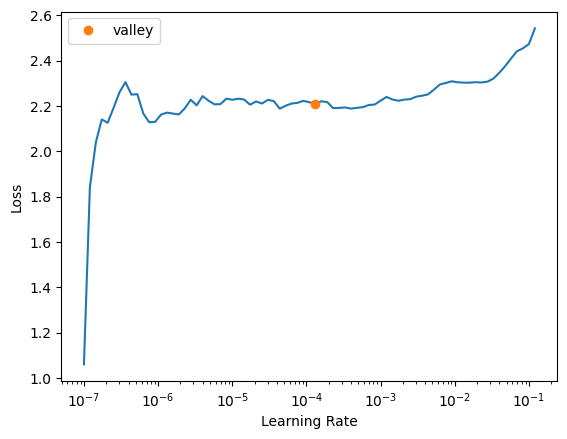

In [34]:
learn.lr_find()